# Official model


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Check if GPU is available


print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
print(f"GPU count: {torch.cuda.device_count()}")
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = 'cpu'
print(f"Using device: {device}")

# import os

PyTorch version: 2.6.0+cpu
CUDA available: False
CUDA version: None
GPU count: 0
Using device: cpu


# Load dataset


In [3]:
from datasets import load_dataset

ds = load_dataset("uoft-cs/cifar10", split="train")
print(ds)

Dataset({
    features: ['img', 'label'],
    num_rows: 50000
})


# Prepare data


In [27]:
from torchvision import transforms

labels_map = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}

images_per_class = 500
transform = transforms.Compose([transforms.PILToTensor()])
images = []
labels = []
for j in range(len(labels_map)):
    num = 0
    for i, data in enumerate(ds):
        label = data["label"]
        if label == j:
            num += 1
            img_tensor = transform(data["img"])
            images.append(img_tensor)
            labels.append(label)

        if num == images_per_class:
            break

# Custom Dataset and DataLoader with train and val data (80%, 20%)


In [28]:
from torch.utils.data import random_split, Dataset


class CustomDataset(Dataset):
    def __init__(self, inputs: torch.Tensor, outputs: torch.Tensor):
        self.inputs = inputs
        self.outputs = outputs

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.outputs[idx]

    def __setitem__(self, idx, value):
        self.inputs[idx] = value


dataset = CustomDataset(images, labels)
train_data, val_data = random_split(dataset, [0.8, 0.2])
print(f"Number of training samples: {len(train_data)}")
print(f"Number of validation samples: {len(val_data)}")

Number of training samples: 4000
Number of validation samples: 1000


In [29]:
from torch.utils.data import DataLoader

BATCH_SIZE = 4

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

print(f"Number of batches in training set: {len(train_loader)}")
print(f"Number of batches in validation set: {len(val_loader)}")

Number of batches in training set: 1000
Number of batches in validation set: 250


In [ ]:
class ConvNet(nn.Module):
    """
    This is simple LeNet
    """

    def __init__(self):

        super(ConvNet, self).__init__()

        self.conv1 = nn.Conv2d(
            3,
            6,
            5,
            padding=2,  # thanks to padding we can also pay more attention to the edges
        )  # 3 input channels, 6 output channels, 5x5 kernel (filter)
        # formula to calculate the output size of the convolutional layer
        # (W−K+2P)/S+1 where W is the input size, K is the kernel size, P is the padding, and S is the stride
        # example: (32-5+2*0)/1+1 = 28
        ###
        # self.pool = nn.MaxPool2d(2, 2)  # 2x2 pooling
        self.pool = nn.AvgPool2d(2, 2)  # LeNet uses average pooling
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 6 * 6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)  # becasue we have 10 different classes
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)

    def forward(self, x):
        x = x.float()
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        x = x.view(-1, 16 * 6 * 6)
        x = F.relu(self.dropout1(self.fc1(x)))
        x = F.relu(self.dropout2(self.fc2(x)))
        x = self.fc3(x)
        return x

In [31]:
model = ConvNet().to(device)
print(model)

ConvNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
)


# Train model


In [33]:
torch.manual_seed(42)
from transformers import get_linear_schedule_with_warmup
from torch import optim
from tqdm import tqdm

lr = 0.0001
optimizer = optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.95), eps=1e-8)
criterion = nn.CrossEntropyLoss()

num_epochs = 10
num_training_steps = len(train_loader) * num_epochs
num_warmup_steps = int(0.1 * num_training_steps)

scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps
)
gradient_accumulation_steps = 1  # Accumulate gradients to simulate larger batch size


lr_history = []
loss_history = []
val_loss_history = []
for epoch in range(num_epochs):
    epoch_loss = 0.0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}")

    for step, (src_data, tgt_data) in enumerate(progress_bar):
        model.train()
        src_data = src_data.to(device)
        tgt_data = tgt_data.to(device)

        output = model(src_data)

        loss = criterion(output, tgt_data)
        loss_history.append(loss.item())
        epoch_loss += loss.item()
        loss = loss / gradient_accumulation_steps

        lr_history.append(optimizer.param_groups[0]["lr"])

        optimizer.zero_grad()  # Reset gradients
        loss.backward()
        torch.nn.utils.clip_grad_norm_(
            model.parameters(), 1.0
        )  # Prevent exploding gradients

        if (step + 1) % gradient_accumulation_steps == 0:
            optimizer.step()  # Update parameters
            scheduler.step()

        # Update progress bar with current loss
        progress_bar.set_postfix(
            {"Batch Loss": loss.item() * gradient_accumulation_steps}
        )
    print(f"Epoch: {epoch + 1}, Loss: {epoch_loss / len(train_loader):.4f}")

    with torch.no_grad():
        model.eval()
        val_loss = 0.0
        for src_data, tgt_data in val_loader:
            src_data = src_data.to(device)
            tgt_data = tgt_data.to(device)
            output = model(src_data)
            loss = criterion(output, tgt_data)
            val_loss += loss.item()
        val_loss_history.append(val_loss / len(val_loader))
        print(f"Validation Loss: {val_loss / len(val_loader):.4f}")

Epoch 1:  84%|████████▎ | 837/1000 [00:14<00:02, 58.72it/s, Batch Loss=1.93] 


KeyboardInterrupt: 

# Show charts with lr and loss


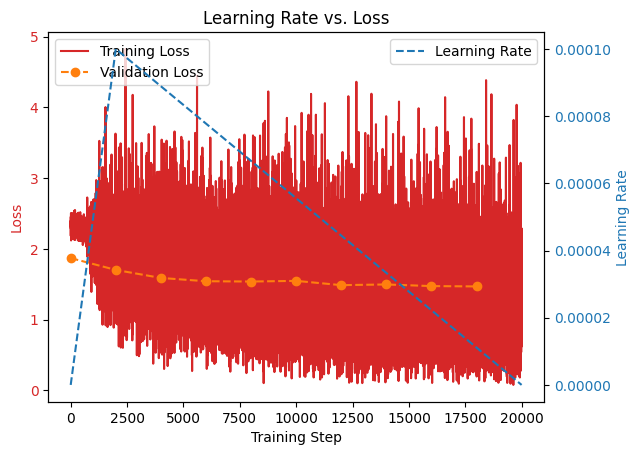

In [25]:
from matplotlib import pyplot as plt

# Ensure all histories are properly formatted
assert len(lr_history) == len(
    loss_history
), "Length of lr_history and loss_history must be the same"

# Create figure and primary y-axis for Loss
fig, ax1 = plt.subplots()

ax1.set_title("Learning Rate vs. Loss")
ax1.set_xlabel("Training Step")
ax1.set_ylabel("Loss", color="tab:red")
ax1.plot(range(len(loss_history)), loss_history, color="tab:red", label="Training Loss")
ax1.tick_params(axis="y", labelcolor="tab:red")

# Plot validation loss (assuming it occurs every 'epoch_interval' steps)
epoch_interval = len(loss_history) // len(val_loss_history)
val_x = [
    i * epoch_interval for i in range(len(val_loss_history))
]  # X values for validation loss
ax1.plot(
    val_x,
    val_loss_history,
    color="tab:orange",
    marker="o",
    linestyle="dashed",
    label="Validation Loss",
)

# Create secondary y-axis for Learning Rate
ax2 = ax1.twinx()
ax2.set_ylabel("Learning Rate", color="tab:blue")
ax2.plot(
    range(len(lr_history)),
    lr_history,
    color="tab:blue",
    linestyle="--",
    label="Learning Rate",
)
ax2.tick_params(axis="y", labelcolor="tab:blue")

# Legends
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.show()

# Model inference


In [26]:
def classify_image(image, model):
    model.eval()  # Set the model to evaluation mode

    src_data = image.unsqueeze(0)

    with torch.no_grad():
        # Generate output (prediction for next token)
        output = model(src_data)
        # print("Output is:", output.shape)

        # Get the last token's logits and find the token with the highest probability
        image_class = output.argmax(dim=-1).item()
        image_class_name = labels_map[image_class]

        return image_class_name


def inference_from_datasets(model, train_dataset: bool = True, index: int = 0):
    if train_dataset:
        dataset = train_loader.dataset
    else:
        dataset = val_loader.dataset
    image = dataset[index][0]
    # print("Image is:", image.shape)
    image_class_name = classify_image(image, model=model)
    if image_class_name == labels_map[dataset[index][1]]:
        return True
    return False

    # print("Dataset:", "Train" if train_dataset else "Validation")
    # print("Generated class:", image_class_name)
    # print("Real translation:", labels_map[dataset[index][1]])


total = 0
for i in range(len(train_loader.dataset)):
    out = inference_from_datasets(model, train_dataset=True, index=i)
    if out:
        total += 1
print("Accuracy on training dataset:", total / len(train_loader.dataset) * 100, "%")

total = 0
for i in range(len(val_loader.dataset)):
    out = inference_from_datasets(model, train_dataset=False, index=i)
    if out:
        total += 1
print("Accuracy on validation dataset:", total / len(val_loader.dataset) * 100, "%")

Accuracy on training dataset: 60.612500000000004 %
Accuracy on validation dataset: 50.849999999999994 %


In [178]:
# PATH = r"my_model_translation.pt"
# torch.save(transformer.state_dict(), PATH)

In [179]:
# next_model = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_src_seq_len,
#                          max_tgt_seq_len, dropout)
# next_model.load_state_dict(torch.load(PATH, weights_only=True))
# next_model = next_model.to(device)
# # print(next_model)
#
# # sentence = tokenizer.decode(train_loader.dataset[0][0].tolist(), skip_special_tokens=True)
# sentence = "What are light beans there?"
# print(sentence)
# # sentence = "Prehistoric humans studied the relationship between the seasons and the length of days to plan their hunting and gathering activities."
# translation = translate_sentence(sentence, tokenizer, next_model)
# print(translation)